### load modules

In [1]:
import os
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from translate import Translator

C:\Users\asus\AppData\Local\Temp/ipykernel_16680/2340277642.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [31]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
! pip3 install googletrans==3.1.0a0

In [4]:
from googletrans import Translator, constants
from pprint import pprint

### load data

In [5]:
item_cat = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [6]:
df_train = pd.read_csv('./data/sales_train.csv')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [9]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [10]:
#convert date to datetime format
df_train['date'] = pd.to_datetime(df_train['date'],format = '%d.%m.%Y')

In [11]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [12]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [13]:
# init the Google API translator
translator = Translator()

In [14]:
def translate(text):
    # translate a spanish text to english text (by default)
    translation = translator.translate(text, dest="en")
    return translation.text

In [15]:
print(translate("! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D"))

! IN THE POWER OF GLAMOR (PLAST.) D


In [ ]:
items['items_english'] = items['item_name'].apply(lambda x: translate(x))

In [ ]:
items

In [16]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [17]:
shops['shop_name_en'] = shops['shop_name'].apply(lambda x: translate(x))

In [18]:
shops

,shop_name,shop_id,shop_name_en
0,"!Якутск Орджоникидзе, 56 фран",0,"!Yakutsk Ordzhonikidze, 56 francs"
1,"!Якутск ТЦ ""Центральный"" фран",1,"!Yakutsk shopping center ""Central"" franc"
2,"Адыгея ТЦ ""Мега""",2,"Adygea shopping center ""Mega"""
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"Balashikha TRC ""October-Kinomir"""
4,"Волжский ТЦ ""Волга Молл""",4,"Volzhsky shopping center ""Volga Mall"""
5,"Вологда ТРЦ ""Мармелад""",5,"Vologda SEC ""Marmalade"""
6,"Воронеж (Плехановская, 13)",6,"Voronezh (Plekhanovskaya, 13)"
7,"Воронеж ТРЦ ""Максимир""",7,"Voronezh TRC ""Maksimir"""
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,"Voronezh SEC City-Park ""Grad"""
9,Выездная Торговля,9,Outbound Trade


In [19]:
#create pivot table
dataset = df_train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset.reset_index(inplace = True)
dataset

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   
...                ...     ...          ...  .. .. .. .. .. .. ..  ... .. ..   
424119              59   22154            1   0  0  0  0  0  0  0  ...  0  0   
424120              59   22155            0   0  0  0  0  0  1  0  ...  0  0   
424121              59   22162            0   0  0  0  0  0  0  0  ...  0  9   
424122              59   22164            0   0  0  0  0  0  0  0  ...  0  2   
424123              59   22167            0   0  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  
...            .. .. .. .. .. .. .. ..  
424119          0  0  0  0  0  0  0  0  
424120          0  0  0  0  0  0  0  0  
424121          4  1  1  0  0  1  0  0  
424122          1  2  0  0  1  0  0  0  
424123          0  0  0  0  0  0  0  0  

[424124 rows x 36 columns]

In [20]:
#Load test set
df_test = pd.read_csv('./data/test.csv')
df_test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [21]:
#merge pivot table with test set
dataset = pd.merge(df_test,dataset,on = ['item_id','shop_id'],how = 'left')

C:\Users\asus\AppData\Local\Temp/ipykernel_16680/1684587006.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  dataset = pd.merge(df_test,dataset,on = ['item_id','shop_id'],how = 'left')
C:\Users\asus\anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [22]:
dataset

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#check for any null values
dataset.isnull().sum()

ID                         0
shop_id                    0
item_id                    0
(item_cnt_day, 0)     102796
(item_cnt_day, 1)     102796
(item_cnt_day, 2)     102796
(item_cnt_day, 3)     102796
(item_cnt_day, 4)     102796
(item_cnt_day, 5)     102796
(item_cnt_day, 6)     102796
(item_cnt_day, 7)     102796
(item_cnt_day, 8)     102796
(item_cnt_day, 9)     102796
(item_cnt_day, 10)    102796
(item_cnt_day, 11)    102796
(item_cnt_day, 12)    102796
(item_cnt_day, 13)    102796
(item_cnt_day, 14)    102796
(item_cnt_day, 15)    102796
(item_cnt_day, 16)    102796
(item_cnt_day, 17)    102796
(item_cnt_day, 18)    102796
(item_cnt_day, 19)    102796
(item_cnt_day, 20)    102796
(item_cnt_day, 21)    102796
(item_cnt_day, 22)    102796
(item_cnt_day, 23)    102796
(item_cnt_day, 24)    102796
(item_cnt_day, 25)    102796
(item_cnt_day, 26)    102796
(item_cnt_day, 27)    102796
(item_cnt_day, 28)    102796
(item_cnt_day, 29)    102796
(item_cnt_day, 30)    102796
(item_cnt_day,

In [24]:
#fill all NaN values with 0
dataset.fillna(0,inplace = True)
dataset.isnull().sum()

ID                    0
shop_id               0
item_id               0
(item_cnt_day, 0)     0
(item_cnt_day, 1)     0
(item_cnt_day, 2)     0
(item_cnt_day, 3)     0
(item_cnt_day, 4)     0
(item_cnt_day, 5)     0
(item_cnt_day, 6)     0
(item_cnt_day, 7)     0
(item_cnt_day, 8)     0
(item_cnt_day, 9)     0
(item_cnt_day, 10)    0
(item_cnt_day, 11)    0
(item_cnt_day, 12)    0
(item_cnt_day, 13)    0
(item_cnt_day, 14)    0
(item_cnt_day, 15)    0
(item_cnt_day, 16)    0
(item_cnt_day, 17)    0
(item_cnt_day, 18)    0
(item_cnt_day, 19)    0
(item_cnt_day, 20)    0
(item_cnt_day, 21)    0
(item_cnt_day, 22)    0
(item_cnt_day, 23)    0
(item_cnt_day, 24)    0
(item_cnt_day, 25)    0
(item_cnt_day, 26)    0
(item_cnt_day, 27)    0
(item_cnt_day, 28)    0
(item_cnt_day, 29)    0
(item_cnt_day, 30)    0
(item_cnt_day, 31)    0
(item_cnt_day, 32)    0
(item_cnt_day, 33)    0
dtype: int64

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  214200 non-null  int64  
 1   shop_id             214200 non-null  int64  
 2   item_id             214200 non-null  int64  
 3   (item_cnt_day, 0)   214200 non-null  float64
 4   (item_cnt_day, 1)   214200 non-null  float64
 5   (item_cnt_day, 2)   214200 non-null  float64
 6   (item_cnt_day, 3)   214200 non-null  float64
 7   (item_cnt_day, 4)   214200 non-null  float64
 8   (item_cnt_day, 5)   214200 non-null  float64
 9   (item_cnt_day, 6)   214200 non-null  float64
 10  (item_cnt_day, 7)   214200 non-null  float64
 11  (item_cnt_day, 8)   214200 non-null  float64
 12  (item_cnt_day, 9)   214200 non-null  float64
 13  (item_cnt_day, 10)  214200 non-null  float64
 14  (item_cnt_day, 11)  214200 non-null  float64
 15  (item_cnt_day, 12)  214200 non-nul

In [26]:
#drop shop_id and item_id
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#split the dataset in two
#keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]
# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)
# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [28]:
# create sequential model
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (33,1)))
my_model.add(Dropout(0.4))
my_model.add(Dense(1))
my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [29]:
#fit the model
history = my_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 41s 702ms/step - loss: 30.5762 - mean_squared_error: 30.5762
Epoch 2/10
53/53 [==============================] - 37s 699ms/step - loss: 30.1936 - mean_squared_error: 30.1936
Epoch 3/10
53/53 [==============================] - 37s 705ms/step - loss: 29.9539 - mean_squared_error: 29.9539
Epoch 4/10
53/53 [==============================] - 38s 708ms/step - loss: 29.8488 - mean_squared_error: 29.8488
Epoch 5/10
53/53 [==============================] - 37s 703ms/step - loss: 29.7417 - mean_squared_error: 29.7417
Epoch 6/10
53/53 [==============================] - 44s 833ms/step - loss: 29.6443 - mean_squared_error: 29.6443
Epoch 7/10
53/53 [==============================] - 40s 757ms/step - loss: 29.6918 - mean_squared_error: 29.6918
Epoch 8/10
53/53 [==============================] - 37s 690ms/step - loss: 29.5941 - mean_squared_error: 29.5941
Epoch 9/10
53/53 [==============================] - 37s 701ms/step - loss: 29.5572 - mean_square

In [37]:
df_his1 = pd.DataFrame(history.history)

In [39]:
df_his1

,loss,mean_squared_error
0,30.576159,30.576159
1,30.193562,30.193562
2,29.953884,29.953884
3,29.848841,29.848841
4,29.741655,29.741655
5,29.644314,29.644314
6,29.691816,29.691816
7,29.594103,29.594103
8,29.557192,29.557192
9,29.540516,29.540516


<AxesSubplot:ylabel='loss'>

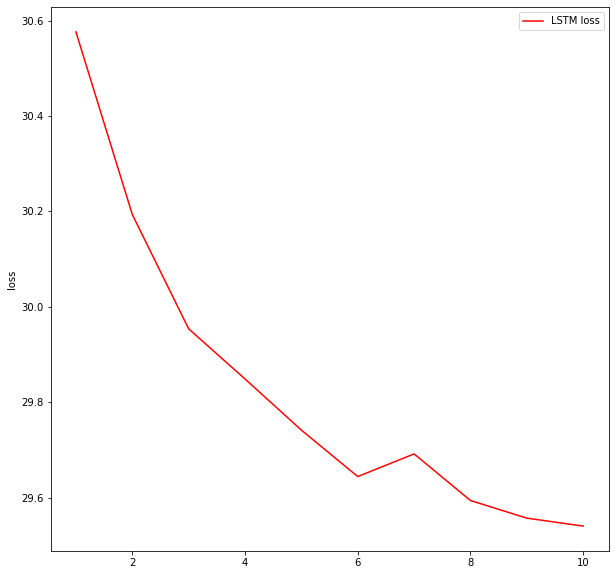

In [38]:
plt.figure(figsize = (10 , 10))
sns.lineplot(x= df_his1.index + 1, y = df_his1['loss'], color='r', label="LSTM loss")

In [ ]:
# creating submission file 
submission_file = my_model.predict(X_test)
# we will keep every value between 0 and 20
submission_file = submission_file.clip(0,20)
# creating dataframe with required columns 
submission_trp = pd.DataFrame({'ID':df_test['ID'],'item_cnt_month':submission_file.ravel()})
# creating csv file from dataframe
submission_trp.to_csv('submission.csv',index = False)
submission_trp

In [41]:
my_model.save('LSTM_RNN_Model.h5')

In [ ]:
import joblib

# save the model to disk
filename = 'lstm_model.pkl'
joblib.dump(my_model, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)


In [ ]:
from google. colab import files
files. download("lstm_model.pkl")